In [1]:
# RSI PowerZones Weekly
import gta_indicator
import gta_plot
import gta_prices
import gta_statistics
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Trade parameters.
exchange = 'LSE'
tidm = 'SVT'
timeframe = 'Weekly'
filename = f'{exchange}_{tidm}_prices.csv'
history_start = '2003-04-04'
p_sma = 40  # Simple Moving Average (SMA) look back period.
p_rsi = 4  # Relative Strength Index (RSI) look back period.
pz1 = 30  # First RSI PowerZone entry level.
pz2 = 25  # Second RSI PowerZone entry level.
pze = 75  # RSI PowerZone exit level.
strategy = f'RSI PowerZones {pz1}-{pze}'
position_size = 1875  # Position size in major currency unit.
charges = 6  # Commission per trade (round trip).
stamp_duty = 0.5  # Stamp Duty percentage.
stop_loss = 20  # Stop Loss percentage.

In [3]:
def state_signal(entry_signal, exit_signal, period):
    '''Calculate trade state signals.'''
    df = pd.concat([entry_signal, exit_signal], axis=1)
    df.columns = ['entry', 'exit']
    df['state'] = 0
    for i in range(period, len(df)):
        if df.loc[df.index[i], 'entry'] == 1 \
        and df.loc[df.index[i - 1], 'state'] == 0:
            df.loc[df.index[i], 'state'] = 1
        elif df.loc[df.index[i], 'exit'] == 1:
            df.loc[df.index[i], 'state'] = 0
        else:
            df.loc[df.index[i], 'state'] = df.loc[df.index[i - 1], 'state']
    return df.state


def trade_list(close, entry_flag, exit_flag):
    '''Generate trade list'''
    frame = pd.concat([close, entry_flag, exit_flag], axis=1)
    frame.columns = ['close', 'entry_flag', 'exit_flag']
    entry_price = frame.close[frame.entry_flag == 1]
    exit_price = frame.close[frame.exit_flag == 1]
    entry_count = len(entry_price)
    exit_count = len(exit_price)
    if exit_count != entry_count:
        last_price = pd.Series(data=frame.close[-1:], index=frame.index[-1:])
        exit_price = exit_price.append(last_price)
        exit_count = len(exit_price)
    df = pd.DataFrame(columns=['entry_price', 'exit_date', 'exit_price'])
    df.entry_price = entry_price
    df.exit_date = exit_price.index
    df.exit_price = exit_price.values
    return df

In [4]:
# Import weekly closing prices.
df = gta_prices.weekly(exchange, tidm, history_start)

In [5]:
# Simple moving average (SMA).
df['sma'] = df.close.rolling(p_sma).mean()
sma = df.sma

# Relative Strength Index (RSI).
df['rsi'] = gta_indicator.rsi(df.close, p_rsi)

In [6]:
# Check closing price is above SMA.
df['trend'] = np.where(df.close > df.sma, 1, 0)

# Check for RSI cross below first PowerZone.
df['pz1'] = np.where(np.logical_and(df.rsi.shift(periods=1) >= pz1, df.rsi < pz1), 1, 0)

# Check whether RSI is below second PowerZone and price is above SMA.
df['pz2'] = np.where(np.logical_and(df.trend == 1, df.rsi < pz2), 1, 0)

# Check for RSI cross above exit level.
df['pze'] = np.where(np.logical_and(df.rsi.shift(periods=1) < pze, df.rsi >= pze), 1, 0)

# Trade #1 entry signal.
df['sig1'] = np.where(np.logical_and(df.trend == 1, df.pz1 == 1), 1, 0)

# Trade #1 state signal.
df['ss1'] = state_signal(df.sig1, df.pze, p_sma)

# Trade #2 entry signal.
df['sig2'] = np.where(np.logical_and(df.ss1.shift(periods=1) == 1, df.pz2 == 1), 1, 0)

# Trade #2 state signal.
df['ss2'] = state_signal(df.sig2, df.pze, p_sma)

# Trade entry & exit flags.
df['en1'] = np.where(np.logical_and(df.ss1 == 1, df.ss1.shift(periods=1) == 0), 1, 0)
df['ex1'] = np.where(np.logical_and(df.ss1 == 0, df.ss1.shift(periods=1) == 1), 1, 0)
df['en2'] = np.where(np.logical_and(df.ss2 == 1, df.ss2.shift(periods=1) == 0), 1, 0)
df['ex2'] = np.where(np.logical_and(df.ss2 == 0, df.ss2.shift(periods=1) == 1), 1, 0)

In [7]:
# Trade list based on RSI exit only (no Stop Loss).
td1 = trade_list(df.close, df.en1, df.ex1)  # Trade List #1.
td2 = trade_list(df.close, df.en2, df.ex2)  # Trade List #2.
td = pd.concat([td1, td2])  # Create full trade list.
td = td.sort_index()  # Sort trades in ascending date order.

# Append trade percentage price change to trade list.
td['chg_pct'] = ((td.exit_price - td.entry_price) / td.entry_price) * 100

In [8]:
# Trade list incorporating Stop Loss.
tdm = pd.DataFrame(columns=['entry_price', 'exit_date', 'exit_price'])
tdm.entry_price = td.entry_price
tdm.exit_date = td.exit_date
tdm.exit_price = td.exit_price

for i in range(0, len(td)):
    # Loop through trade list based on RSI exit and check if stop is triggered.
    ps = pd.DataFrame(columns=['close', 'stop', 'exit'])
    ps.close = df.close.loc[td.index[i] : td.exit_date[i]]
    ps.stop = ps.close[0] * (1 - (stop_loss / 100))
    ps.exit = np.where(ps.close < ps.stop, 1, 0)

    # Create modified trade list incorporating Stop Loss.
    if ps.exit.sum() > 0:
        exit_date = ps.exit.idxmax(axis=1, skipna=True)
        tdm.loc[tdm.index[i], 'exit_date'] = exit_date
        tdm.loc[tdm.index[i], 'exit_price'] = ps.close.loc[exit_date]
    else:
        tdm.loc[tdm.index[i], 'exit_date'] = td.loc[td.index[i], 'exit_date']
        tdm.loc[tdm.index[i], 'exit_price'] = td.loc[td.index[i], 'exit_price']

# Cumulative profit after costs.
tdm['weeks'] = (tdm.exit_date - tdm.index) / np.timedelta64(1, 'W')
tdm['chg_pct'] = ((tdm.exit_price - tdm.entry_price) / tdm.entry_price) * 100
tdm['charges'] = charges
tdm['stamp_duty'] = position_size * (stamp_duty / 100)
tdm['profit'] = position_size * (tdm.chg_pct / 100) - tdm.charges - tdm.stamp_duty
tdm['cum_profit'] = tdm.profit.cumsum()
cum_profit = tdm.cum_profit
tdm.round(2)

entry_price  exit_date  exit_price  weeks  chg_pct  charges  \
date                                                                      
2004-01-16         7.45 2004-02-27        7.80    6.0     4.73        6   
2005-01-28         9.72 2005-04-29       10.21   13.0     5.04        6   
2005-03-04         9.52 2005-04-29       10.21    8.0     7.19        6   
2005-08-12        10.09 2005-09-09       10.78    4.0     6.89        6   
2007-01-12        14.15 2007-05-04       15.24   16.0     7.70        6   
2007-01-19        13.89 2007-05-04       15.24   15.0     9.72        6   
2008-01-25        14.48 2008-04-25       15.03   13.0     3.80        6   
2010-04-30        11.59 2010-06-11       12.46    6.0     7.51        6   
2010-05-07        10.86 2010-06-11       12.46    5.0    14.73        6   
2011-01-21        14.01 2011-03-04       15.08    6.0     7.64        6   
2011-01-28        13.91 2011-03-04       15.08    5.0     8.41        6   
2011-06-10        14.46 2011-09-30       15.41   16.0     6.57        6   
2012-06-22        16.06 2013-03-22       16.83   39.0     4.79        6   
2013-06-14        17.60 2013-09-20       18.20   14.0     3.41        6   
2014-08-01        18.77 2014-09-05       19.95    5.0     6.29        6   
2014-09-26        18.74 2014-10-24       19.88    4.0     6.08        6   
2014-10-03        18.67 2014-10-24       19.88    3.0     6.48        6   
2015-06-19        20.55 2015-10-02       22.15   15.0     7.79        6   
2015-11-13        21.34 2016-04-08       22.39   21.0     4.92        6   
2016-10-07        23.25 2017-02-10       23.04   18.0    -0.90        6   
2019-08-09        19.87 2019-09-27       21.48    7.0     8.10        6   
2020-03-13        22.73 2020-06-05       24.79   12.0     9.06        6   
2021-09-24        26.93 2021-11-12       28.30    7.0     5.09        6   
2021-10-01        26.03 2021-11-12       28.30    6.0     8.72        6   
2022-02-04        28.32 2022-02-04       28.32    0.0     0.00        6   

            stamp_duty  profit  cum_profit  
date                                        
2004-01-16        9.38   73.39       73.39  
2005-01-28        9.38   79.10      152.50  
2005-03-04        9.38  119.40      271.90  
2005-08-12        9.38  113.78      385.67  
2007-01-12        9.38  129.06      514.73  
2007-01-19        9.38  166.86      681.59  
2008-01-25        9.38   55.84      737.44  
2010-04-30        9.38  125.37      862.81  
2010-05-07        9.38  260.87     1123.67  
2011-01-21        9.38  127.83     1251.50  
2011-01-28        9.38  142.34     1393.84  
2011-06-10        9.38  107.81     1501.65  
2012-06-22        9.38   74.52     1576.17  
2013-06-14        9.38   48.55     1624.71  
2014-08-01        9.38  102.50     1727.21  
2014-09-26        9.38   98.69     1825.90  
2014-10-03        9.38  106.14     1932.04  
2015-06-19        9.38  130.61     2062.65  
2015-11-13        9.38   76.88     2139.53  
2016-10-07        9.38  -32.31     2107.22  
2019-08-09        9.38  136.55     2243.77  
2020-03-13        9.38  154.55     2398.33  
2021-09-24        9.38   80.01     2478.34  
2021-10-01        9.38  148.14     2626.48  
2022-02-04        9.38  -15.38     2611.10

In [9]:
# Trade statistics.
ts = gta_statistics.summary(exchange, tidm, strategy, timeframe, sma, position_size, tdm)
ts

Exchange                                     LSE
TIDM                                         SVT
Strategy                    RSI PowerZones 30-75
Timeframe                                 Weekly
Start Date                            2004-01-02
End Date                              2022-02-04
Analysis Years                              18.1
Position Size                           1,875.00
Net Profit                              2,611.10
Annual %                                     4.9
Charges                                   150.00
Stamp Duty                                234.38
Total Trades                                  25
Winning Trades                                23
Losing Trades                                  1
Winning %                                   92.0
Trades per Year                              1.4
Average Profit %                             6.4
Average Profit                            104.44
Average Weeks                               10.6
Average Winning Prof

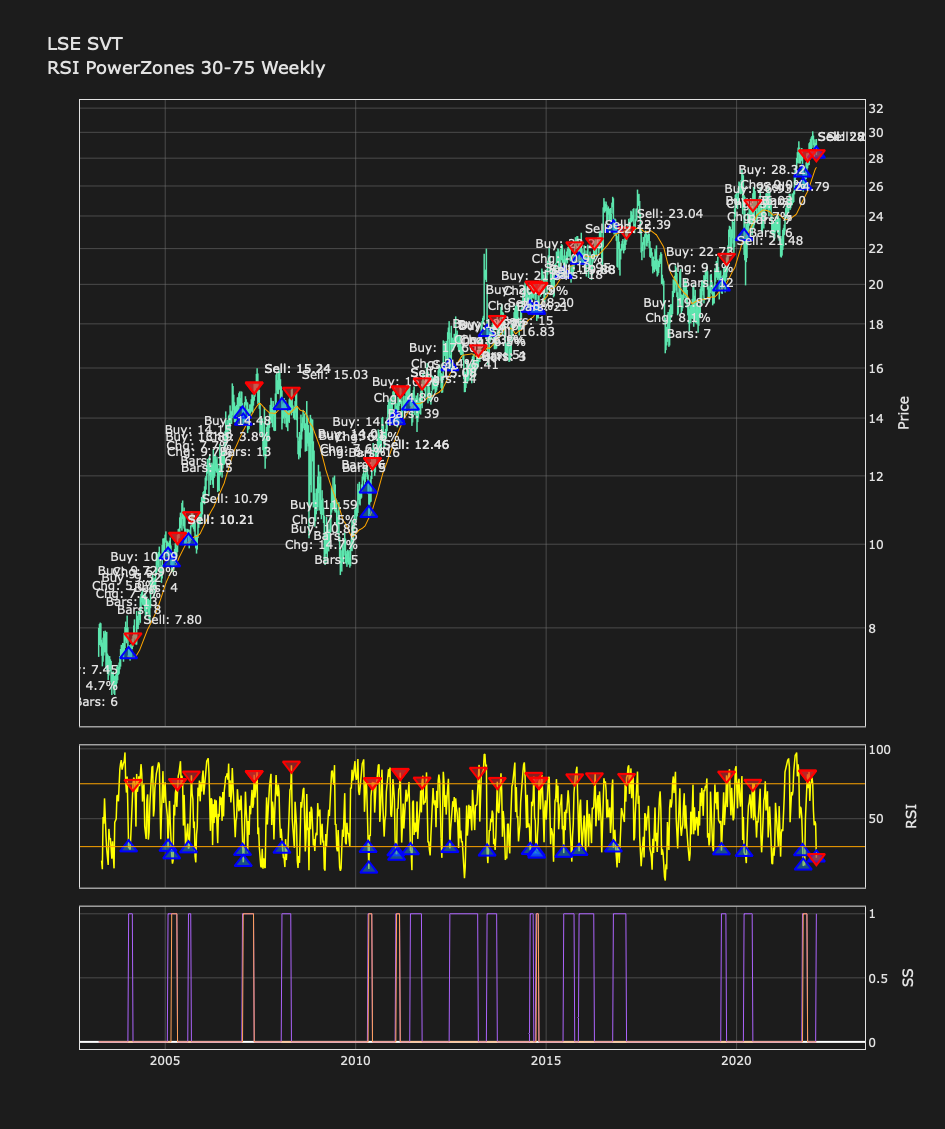

In [10]:
# Customise plot hovertext.
hovertext_ohlc = []
for i in range(len(df.open)):
    hovertext_ohlc.append(
        str(df.index[i].strftime('%Y-%m-%d'))
        + '<br>O: '
        + str('{0:.2f}'.format(df.open[i]))
        + '<br>H: '
        + str('{0:.2f}'.format(df.high[i]))
        + '<br>L: '
        + str('{0:.2f}'.format(df.low[i]))
        + '<br>C: '
        + str('{0:.2f}'.format(df.close[i]))
    )

hovertext_sma = []
for i in range(len(df.open)):
    hovertext_sma.append(f'{p_sma} SMA: ' + str('{0:.2f}'.format(df.sma[i])))

hovertext_rsi = []
for i in range(len(df.open)):
    hovertext_rsi.append(
        str(df.index[i].strftime('%Y-%m-%d'))
        + f'<br>{p_rsi} RSI: '
        + str('{0:.1f}'.format(df.rsi[i]))
    )

hovertext_ss1 = []
for i in range(len(df.open)):
    hovertext_ss1.append(
        str(df.index[i].strftime('%Y-%m-%d'))
        + f'<br>SS1: '
        + str('{0:.0f}'.format(df.ss1[i]))
    )

hovertext_ss2 = []
for i in range(len(df.open)):
    hovertext_ss2.append(f'<br>SS2: ' + str('{0:.0f}'.format(df.ss2[i])))

hovertext_buy = []
for i in range(len(tdm.index)):
    hovertext_buy.append(
        f'Buy: '
        + str('{0:.2f}'.format(tdm.entry_price[i]))
        + f'<br>Chg: '
        + str('{0:.1f}'.format(tdm.chg_pct[i]))
        + '%'
        + f'<br>Bars: '
        + str('{0:.0f}'.format(tdm.weeks[i]))
    )

hovertext_sell = []
for i in range(len(tdm.index)):
    hovertext_sell.append(f'Sell: ' + str('{0:.2f}'.format(tdm.exit_price[i])))

# Create plot traces.
trace_ohlc = go.Ohlc(
    x=df.index,
    open=df.open,
    high=df.high,
    low=df.low,
    close=df.close,
    increasing_line_color='rgba(92, 230, 174, 1.0)',
    decreasing_line_color='rgba(92, 230, 174, 1.0)',
    line_width=1.5,
    text=hovertext_ohlc,
    hoverinfo='text',
)

trace_sma = go.Scatter(
    x=df.index,
    y=df.sma,
    line=dict(color='orange', width=1.0),
    text=hovertext_sma,
    hoverinfo='text',
)

trace_rsi = go.Scatter(
    x=df.index,
    y=df.rsi,
    line=dict(color='yellow', width=1.5),
    text=hovertext_rsi,
    hoverinfo='text',
)

trace_ss1 = go.Scatter(
    x=df.index, y=df.ss1, line=dict(width=1.0), text=hovertext_ss1, hoverinfo='text',
)

trace_ss2 = go.Scatter(
    x=df.index, y=df.ss2, line=dict(width=1.0), text=hovertext_ss2, hoverinfo='text',
)

trace_ohlc_buy = go.Scatter(
    x=tdm.index,
    y=tdm.entry_price,
    name='Buy',
    mode='markers+text',
    marker_symbol='triangle-up',
    marker=dict(
        color='rgba(28, 134, 238, 0.5)', size=15, line=dict(color='Blue', width=2)
    ),
    text=hovertext_buy,
    textposition='bottom left',
    hoverinfo='text',
)

trace_ohlc_sell = go.Scatter(
    x=tdm.exit_date,
    y=tdm.exit_price,
    name='Sell',
    mode='markers+text',
    marker_symbol='triangle-down',
    marker=dict(
        color='rgba(238, 44, 44, 0.5)', size=15, line=dict(color='Red', width=2)
    ),
    text=hovertext_sell,
    textposition='top right',
    hoverinfo='text',
)

trace_rsi_buy = go.Scatter(
    x=tdm.index,
    y=df.rsi[tdm.index],
    name='Buy',
    mode='markers',
    marker_symbol='triangle-up',
    marker=dict(
        color='rgba(28, 134, 238, 0.5)', size=15, line=dict(color='Blue', width=2)
    ),
    text='Buy',
    hoverinfo='text',
)

trace_rsi_sell = go.Scatter(
    x=tdm.exit_date,
    y=df.rsi[tdm.exit_date],
    name='Sell',
    mode='markers',
    marker_symbol='triangle-down',
    marker=dict(
        color='rgba(238, 44, 44, 0.5)', size=15, line=dict(color='Red', width=2)
    ),
    text='Sell',
    hoverinfo='text',
)

# Create figure and add traces.
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02,)
fig.add_trace(trace_ohlc, row=1, col=1)
fig.add_trace(trace_sma, row=1, col=1)
fig.add_trace(trace_rsi, row=2, col=1)
fig.add_hline(y=pz1, row=2, col=1, line=dict(color='orange', width=1.0))
fig.add_hline(y=pze, row=2, col=1, line=dict(color='orange', width=1.0))
fig.add_trace(trace_ss1, row=3, col=1)
fig.add_trace(trace_ss2, row=3, col=1)
fig.add_trace(trace_ohlc_buy, row=1, col=1)
fig.add_trace(trace_ohlc_sell, row=1, col=1)
fig.add_trace(trace_rsi_buy, row=2, col=1)
fig.add_trace(trace_rsi_sell, row=2, col=1)

# Customise plot layout.
fig.update_layout(
    autosize=True,
    showlegend=False,
    yaxis_domain=[0.34, 1],
    yaxis2_domain=[0.17, 0.32],
    yaxis3_domain=[0, 0.15],
    paper_bgcolor='rgba(28, 28, 28, 1.0)',
    plot_bgcolor='rgba(28, 28, 28, 1.0)',
    font=dict(color='rgba(226, 226, 226, 1.0)'),
    title=dict(
        text=f'{exchange} {tidm}'
        + f'<br>{strategy} {timeframe}',
        font_color='rgba(226, 226, 226, 1.0)',
        font_size=18,
    ),
    xaxis=dict(rangeslider=dict(visible=False)),
    hovermode='x unified',
    hoverlabel=dict(bgcolor='rgba(28, 28, 28, 0.5)'),
    dragmode='pan',
)

# Customise plot axes.
fig.update_xaxes(
    linecolor='rgba(226, 226, 226, 1.0)',
    gridcolor='rgba(119, 119, 119, 0.5)',
    mirror=True,
)

fig.update_yaxes(
    linecolor='rgba(226, 226, 226, 1.0)',
    gridcolor='rgba(119, 119, 119, 0.5)',
    mirror=True,
)

fig.update_yaxes(row=1, col=1, side='right', title='Price', type='log')
fig.update_yaxes(row=2, col=1, side='right', title='RSI')
fig.update_yaxes(row=3, col=1, side='right', title='SS')

# Display plot.
fig.show(
    config={
        'scrollZoom': True,
        'modeBarButtonsToRemove': ['zoom', 'select2d', 'lasso2d'],
    }
)

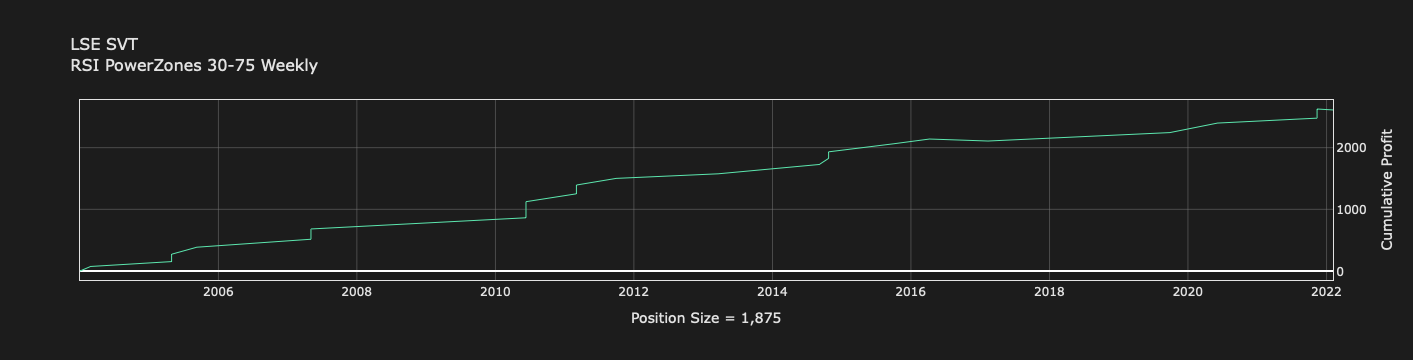

In [11]:
gta_plot.cum_profit(exchange, tidm, strategy, timeframe, sma, position_size, tdm)